Importing necessary libraries / scikitlearn models here 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Loading dataset from url link and creating dataframe. Normalizing data here as well by using Sunspots to make prediction and setting a range of 0-1 for the data being represented. Splitting normalized data into 80-20 test-train split.

In [22]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
df = pd.read_csv(url)

data = df['Sunspots'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size:]
train_data = scaled_data[:train_size]

Sequence Creation Function (Sliding Window Concept) to analyze current sequence and predict next item for the sequence.

In [23]:
def create_sequences(dataset, look_back=1):
    x, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        x.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(x), np.array(y)

Defining the look back period and reshaping input format to be [samples, time steps, features] for the LSTM RNN Model. Reshaping input for dense to [samples, features] (time steps is flattened)

In [24]:
# Look Back set to 11 to remain within 60-70 parameter limit, if it were 12 the fully connected model would have 71 parameters
look_back = 11

x_train, y_train = create_sequences(train_data, look_back)
x_test, y_test = create_sequences(test_data, look_back)

# Reshape input for LSTM RNN
x_train_lstm = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Reshape for Dense
x_train_dense = x_train
x_test_dense = x_test

Building Both RNN Models

In [25]:
# --- Model A: Fully Connected RNN Model ---
# 11 Inputs -> 5 Neurons -> 1 Output
# Params: (11*5 + 5) + (5*1 + 1) = 60 + 6 = 66 Parameters
model_fc = Sequential([
    Dense(5, input_dim=look_back, activation=tf.nn.leaky_relu),
    Dense(1)
])
model_fc.compile(optimizer='adam', loss='mse')

# --- Mdel B: LSTM RNN Model ---
# 3 Units
# Params: 4 * ((1 feature + 1 bias) * 3 units + 3 units^2) = 60 LSTM params
# Output Dense: 3 inputs * 1 output + 1 bias = 4 dense params
# Total: 64 Parameters
model_lstm = Sequential([
    LSTM(3, input_shape=(look_back, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')


c:\Users\Greg\Documents\dev\machine-learning-fall25\rnn-models\rnnvenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Greg\Documents\dev\machine-learning-fall25\rnn-models\rnnvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Verifying Parameters, training Both Models, Creating Predictions / Evals and Inverse Scaling data

In [26]:
# Verifying Params Counts
print(f"Fully Connected Params: {model_fc.count_params()}")
print(f"LSTM Params: {model_lstm.count_params()}")

# Training Models
print("\nTraining Fully Connected Model...")
model_fc.fit(x_train_dense, y_train, epochs=50, batch_size=32, verbose=1)
print("\nTraining LSTM Model...")
model_lstm.fit(x_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Creating Predictions
fc_prediction = model_fc.predict(x_test_dense)
lstm_prediction = model_lstm.predict(x_test_lstm)
y_test_array = np.array(y_test).reshape(-1, 1)

# Invert scaling
real_y = scaler.inverse_transform(y_test_array).flatten()
inverted_fc_pred = scaler.inverse_transform(fc_prediction).flatten()
inverted_lstm_pred = scaler.inverse_transform(lstm_prediction).flatten()

Fully Connected Params: 66
LSTM Params: 64

Training Fully Connected Model...
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0134 
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0089
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0079
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0072
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0066
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0063
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0059
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0056
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0053
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0051
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0049
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0047
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0046
Epoch 14/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 811u

MSE Calculation / Plotting Predictions


Final MSE Results:
Fully Connected (66 params): 351.03
LSTM (64 params):            382.89


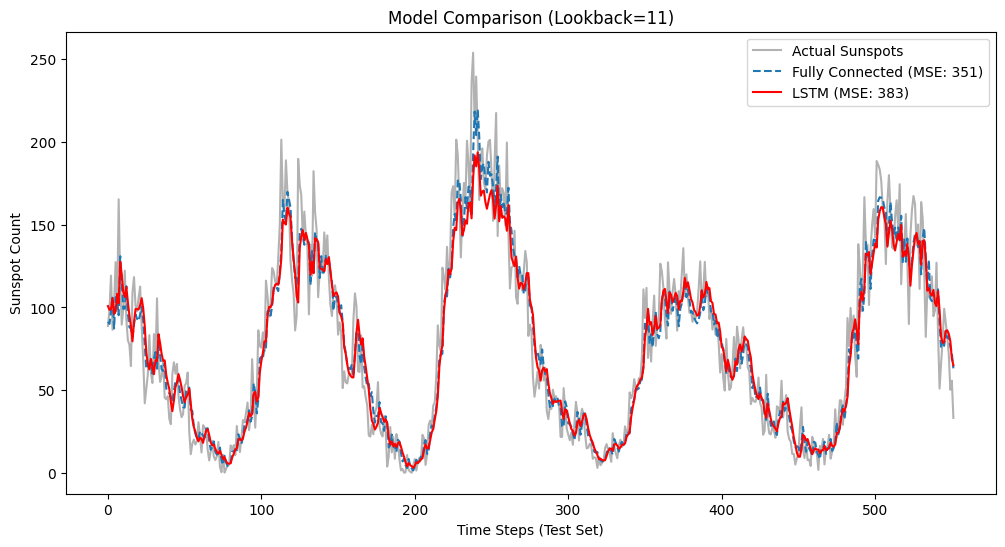

In [27]:
# MSE Calculation for both models
mse_fc = mean_squared_error(real_y, inverted_fc_pred)
mse_lstm = mean_squared_error(real_y, inverted_lstm_pred)

# Printed MSE Calculations
print(f"\nFinal MSE Results:")
print(f"Fully Connected (66 params): {mse_fc:.2f}")
print(f"LSTM (64 params):            {mse_lstm:.2f}")

# Plotting Predictions
plt.figure(figsize=(12,6))
plt.plot(real_y, label='Actual Sunspots', color='black', alpha=0.3)
plt.plot(inverted_fc_pred, label=f'Fully Connected (MSE: {mse_fc:.0f})', linestyle='--')
plt.plot(inverted_lstm_pred, label=f'LSTM (MSE: {mse_lstm:.0f})', color='red')
plt.title(f'Model Comparison (Lookback={look_back})')
plt.xlabel('Time Steps (Test Set)')
plt.ylabel('Sunspot Count')
plt.legend()
plt.show()

Result Justification:

Even though the parameter counts are very identical the LSTM should achiieve a lower MSE due to these factors.

The LSTM model has temporal context in terms of the data so it analyzes the readings of sunspots in order while the Fully Connected Model does not have the context and just views the inputs as different features.

Additionally, the LSTM reuses the weights created / modified across time when viewing data inputted.

Although the aboce should be true, with the dataset being as small as it is the Fully Connected Model outperforms the LSTM model as it optimizes faster on smaller datasets whereas the LSTM model requires more iterations to effectively learn the temporal gate mechanisms.
